# Wide Conv Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [13]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-wideconv-fix-params-and-seed',))]

In [14]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] not in ('mpcnn', 'mpcnn_no_per_dim_no_multi_pooling'):
        continue
    
    if 'wide_conv' in args:
        arch = 'Wide Conv'
    else:
        arch = 'Narrow Conv'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [15]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [16]:
trecqa['seed'].unique()

array([428038, 765364, 384200, 843412, 581900, 243649, 160893, 929510,
       474441, 900850])

In [17]:
trecqa['arch'].unique()

array(['Narrow Conv', 'Wide Conv'], dtype=object)

In [18]:
archs = ['Narrow Conv', 'Wide Conv']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'Narrow Conv')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')

## TrecQA

In [19]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [20]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Narrow Conv: (0.7676, 0.7844)
Wide Conv: (0.7649, 0.7846)


In [21]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Narrow Conv: (0.8317, 0.8493)
Wide Conv: (0.8347, 0.8553)


In [22]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Narrow Conv,0.77600,571225.7
Wide Conv,0.77478,571225.7


In [23]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Narrow Conv,0.84048,571225.7
Wide Conv,0.84500,571225.7


In [24]:
trec_map_vs_archs_test.sort_values('seed')

,arch,dataset,metric_name,metric_val,seed,split
54,Wide Conv,trecqa,MAP,0.7555,160893,test
50,Narrow Conv,trecqa,MAP,0.7757,160893,test
46,Wide Conv,trecqa,MAP,0.7838,243649,test
42,Narrow Conv,trecqa,MAP,0.7859,243649,test
18,Narrow Conv,trecqa,MAP,0.7650,384200,test
22,Wide Conv,trecqa,MAP,0.7735,384200,test
2,Narrow Conv,trecqa,MAP,0.7795,428038,test
6,Wide Conv,trecqa,MAP,0.7618,428038,test
70,Wide Conv,trecqa,MAP,0.7921,474441,test
66,Narrow Conv,trecqa,MAP,0.7814,474441,test


In [25]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Narrow Conv
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: Wide Conv
Median of MAP change compared with single baseline: -0.0035
Mean of MAP change compared with single baseline: -0.0012


In [26]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Narrow Conv
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: Wide Conv
Median of MRR change compared with single baseline: 0.0070
Mean of MRR change compared with single baseline: 0.0045


## WikiQA

In [27]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [28]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Narrow Conv: (0.6831, 0.6999)
Wide Conv: (0.6874, 0.7025)


In [29]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Narrow Conv: (0.6975, 0.7151)
Wide Conv: (0.7021, 0.7183)


In [30]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Narrow Conv,0.69152,571225.7
Wide Conv,0.69494,571225.7


In [31]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Narrow Conv,0.70627,571225.7
Wide Conv,0.71018,571225.7


In [32]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Narrow Conv
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: Wide Conv
Median of MAP change compared with single baseline: 0.0020
Mean of MAP change compared with single baseline: 0.0034


In [33]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Narrow Conv
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: Wide Conv
Median of MRR change compared with single baseline: 0.0021
Mean of MRR change compared with single baseline: 0.0039


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,  0.73,  0.74]),
 <a list of 10 Text yticklabel objects>)

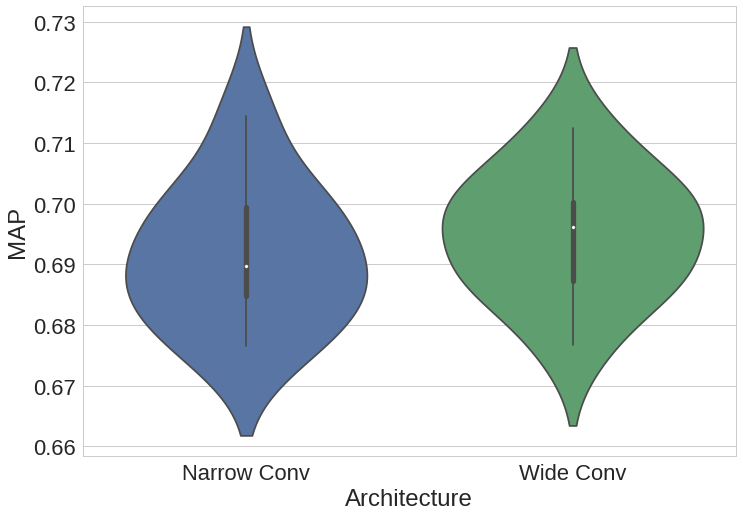

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.6, 0.75)

## SICK

In [35]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [36]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Narrow Conv: (0.8634, 0.8701)
Wide Conv: (0.8709, 0.8763)


In [37]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

Narrow Conv: (0.7995, 0.8065)
Wide Conv: (0.8097, 0.8175)


In [38]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Narrow Conv,0.866767,571225.7
Wide Conv,0.873600,571225.7


In [39]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Narrow Conv,0.802988,571225.7
Wide Conv,0.813607,571225.7


In [40]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Narrow Conv
Median of pearson change compared with single baseline: 0.0000
Mean of pearson change compared with single baseline: 0.0000
Architecture: Wide Conv
Median of pearson change compared with single baseline: 0.0062
Mean of pearson change compared with single baseline: 0.0068


In [41]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Narrow Conv
Median of spearman change compared with single baseline: 0.0000
Mean of spearman change compared with single baseline: 0.0000
Architecture: Wide Conv
Median of spearman change compared with single baseline: 0.0088
Mean of spearman change compared with single baseline: 0.0106


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.85 ,  0.855,  0.86 ,  0.865,  0.87 ,  0.875,  0.88 ,  0.885,
         0.89 ]), <a list of 9 Text yticklabel objects>)

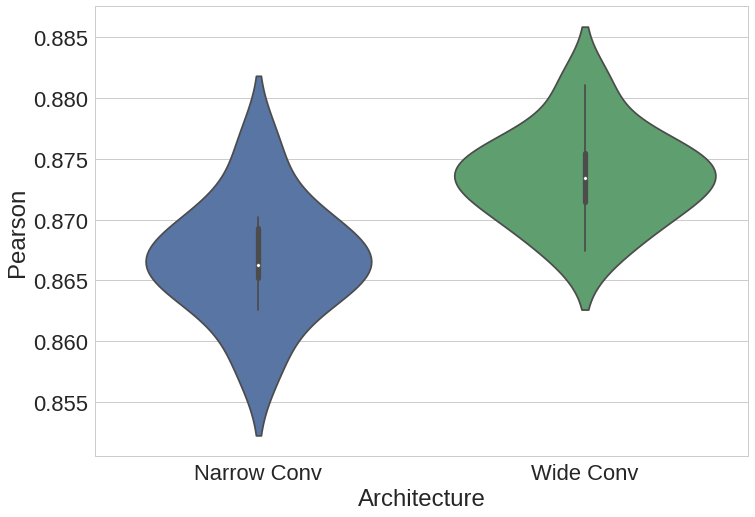

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)

/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


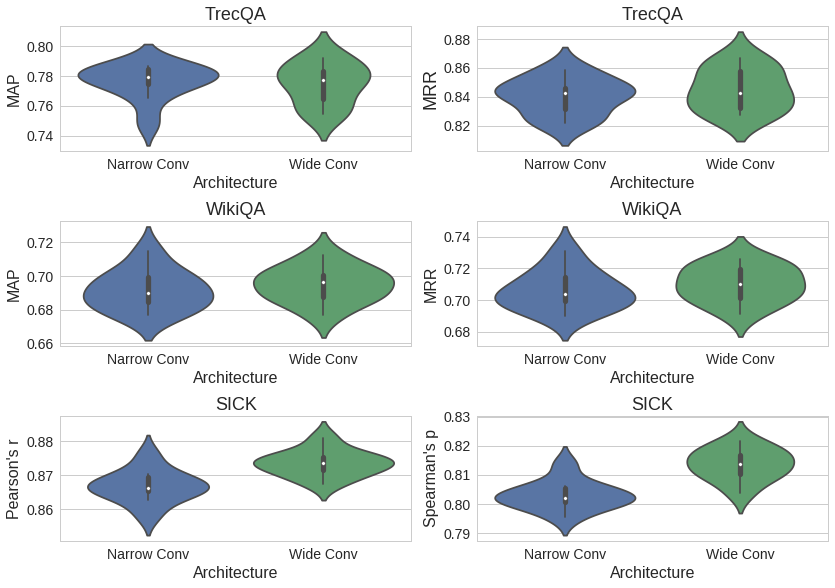

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()